<a href="https://colab.research.google.com/github/Helen-Jiang719/COMP558_final_project/blob/main/COMP_551_A1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [349]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sb
from prettytable import PrettyTable
from scipy.stats import pointbiserialr
from tabulate import tabulate
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix

**KNN**

In [319]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
hamming = lambda x1, x2: np.sum(x1 != x2, axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= manhattan):
        self.dist_fn = dist_fn
        self.K = K
        return

    def fit(self, x, y):
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self

    def predict(self, x_test):
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C)
        return y_prob, knns

    def evaluate_acc(self, y_pred, y_test):
          accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
          return accuracy

**Weighted KNN**

In [229]:
class WeightedKNN:
    def __init__(self, K=1, dist_fn=manhattan, similarity_fn=None):
        self.K = K
        self.dist_fn = dist_fn
        self.similarity_fn = similarity_fn if similarity_fn else self.inverse_distance_similarity

    @staticmethod
    def inverse_distance_similarity(distances):
        return 1 / (distances + 1e-6)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.C = np.max(y_train) + 1
        return self

    def predict(self, X_test):
        num_test = X_test.shape[0]
        distances = cdist(X_test, self.X_train, metric=self.dist_fn)
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test, self.C))

        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            # calculate similarities based on distances
            similarities = self.similarity_fn(distances[i, knns[i,:]])
            # normalize similarities
            normalization_factor = np.sum(similarities)
            normalized_similarities = similarities / normalization_factor if normalization_factor != 0 else similarities

            # weighted voting for each class based on the similarity
            for c in range(self.C):
                class_mask = (self.y_train[knns[i,:]] == c).astype(float)
                y_prob[i, c] = np.sum(normalized_similarities * class_mask)

        return y_prob, knns

    def evaluate_acc(self, y_pred, y_test):
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        return accuracy

**K-fold validation**

In [195]:
def k_fold_cross_validation_sklearn(X, y, K_values, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    accuracies_weighted = {k: [] for k in K_values}
    accuracies_knn = {k: [] for k in K_values}

    # validation through each fold
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # train and validate Weighted KNN
        for k in K_values:
            model = WeightedKNN(K=k)
            model.fit(X_train, y_train)
            y_prob, _ = model.predict(X_val)
            y_pred = np.argmax(y_prob, axis=-1)

            # Accuracy evaluation
            accuracy = np.sum(y_pred == y_val) / y_val.shape[0]
            accuracies_weighted[k].append(accuracy)

        # train and validate simple KNN
        for k in K_values:
            model = KNN(K=k)
            model.fit(X_train, y_train)
            y_prob, _ = model.predict(X_val)
            y_pred = np.argmax(y_prob, axis=-1)

            accuracy = np.sum(y_pred == y_val) / y_val.shape[0]
            accuracies_knn[k].append(accuracy)

    return accuracies_weighted, accuracies_knn

**Decision Tree**

In [5]:
from IPython.core.debugger import set_trace
np.random.seed(1234)

Data structure

In [472]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent
            self.num_classes = parent.num_classes           #copies the num classes from the parent
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node

Greedy test for Penguins

In [473]:
def greedy_test_penguins(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue
            #compute the left and right cost based on the current split
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

Greedy test for Heart Disease

In [474]:
def greedy_test(node, cost_fn, feature_types=None, num_features = 11):
    best_cost = np.inf
    best_feature = None
    best_value = None

    num_instances = node.data.shape[0]

    for f in range(num_features):
        feature_type = feature_types[f]
        data_f = node.data[node.data_indices, f]

        if feature_type == 'n':
            # compute candidate split points for numerical features
            data_sorted = np.sort(data_f)
            test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2  # 相邻值的中点

            for test in test_candidates:
                # split the data into left and right child nodes based on the split point
                left_indices = node.data_indices[data_f <= test]
                right_indices = node.data_indices[data_f > test]

                # split if no samples
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                # compute cost after the split
                left_cost = cost_fn(node.labels[left_indices])
                right_cost = cost_fn(node.labels[right_indices])
                num_left, num_right = len(left_indices), len(right_indices)
                cost = (num_left * left_cost + num_right * right_cost) / num_instances

                # update best split
                if cost < best_cost:
                    best_cost = cost
                    best_feature = f
                    best_value = test

        elif feature_type == 'c':
            # compute candidate split points for categorical features
            unique_values = np.unique(data_f)

            for value in unique_values:
                # split the data based on category values
                left_indices = node.data_indices[data_f == value]
                right_indices = node.data_indices[data_f != value]

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                # compute the cost after the split
                left_cost = cost_fn(node.labels[left_indices])
                right_cost = cost_fn(node.labels[right_indices])
                num_left, num_right = len(left_indices), len(right_indices)
                cost = (num_left * left_cost + num_right * right_cost) / num_instances

                # update the best split
                if cost < best_cost:
                    best_cost = cost
                    best_feature = f
                    best_value = value
                    # The split point for a categorical feature is a category value

    return best_cost, best_feature, best_value

Cost functions

In [462]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]
    return -np.sum(class_probs * np.log2(class_probs))

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))

Build tree

In [494]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination
        self.root = None                #stores the root of the decision tree
        self.cost_fn = cost_fn          #stores the cost function of the decision tree
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        self.feature_importances = None
        self.feature_importances_gini = None

    def fit(self, data, labels):
        pass


    def predict(self, data_test):
        pass

    def predict_proba(self, x_test):
        return self.predict(x_test)

    def traverse_tree(self):
        self.dfs(self.root)

    def dfs(self, node):
      if node.left is None and node.right is None:
        return

      self.feature_importances[node.split_feature] +=1

      # gini reduction
      # total number of samples in the current node:
      n_total = len(node.data_indices)
      if n_total == 0:
        return

      # num of samples in left and right  nodes
      n_left = len(node.left.data_indices) if node.left else 0
      n_right = len(node.right.data_indices) if node.right else 0

      # gini index of parent and child nodes
      gini_parent = cost_gini_index(node.labels)
      gini_left = cost_gini_index(node.left.labels)
      gini_right = cost_gini_index(node.right.labels)

      # compute gini reduction
      gini_reduction = (
          gini_parent
          - (n_left / n_total) * gini_left
          - (n_right / n_total) * gini_right
      )

      # update gini importance
      self.feature_importances_gini[node.split_feature] += gini_reduction

      self.dfs(node.left)
      self.dfs(node.right)

In [497]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1

    self.feature_importances = np.zeros(data.shape[1])
    self.feature_importances_gini = np.zeros(data.shape[1])

    # initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0

    # recursively build the rest of the tree
    self._fit_tree(self.root)
    return self


def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn, feature_types)

    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right


DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right

        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

**Helper Functions**

In [173]:
def standadization(x):
  x = x.copy().to_numpy()
  x_mean = np.mean(x, axis=0)
  x_std = np.std(x, axis=0)
  return (x - x_mean) / x_std

# two ways to split data:
# 1. 2-split 50%/50%
def split_data(x, y, train_ratio=0.5):
    N = len(x)
    train_size = int(train_ratio * N)
    inds = np.random.permutation(N)
    x_train, y_train = x[inds[:train_size]], y[inds[:train_size]]
    x_test, y_test = x[inds[train_size:]], y[inds[train_size:]]
    return x_train, y_train, x_test, y_test

# 2. 3-split
def split_data_three(x, y):
    N = len(x)
    inds = np.random.permutation(N)
    part_size = N // 3

    x_train, y_train = x[inds[:part_size]], y[inds[:part_size]]
    x_validation, y_validation = x[inds[part_size:2 * part_size]], y[inds[part_size:2 * part_size]]
    x_test, y_test = x[inds[2 * part_size:]], y[inds[2 * part_size:]]

    return x_train, y_train, x_validation, y_validation,x_test, y_test


**Functions for running experiment**

In [97]:
def best_K_simple(x_train, y_train, x_test, y_test,KNN_type):
    K_values = range(1, 21)
    accuracies = []
    train_acc = []
    n_train = y_train.shape[0]

    # loop through k value 1-20
    for k in K_values:

        model = KNN_type(K=k)
        y_prob, _ = model.fit(x_train, y_train).predict(x_test)
        y_pred = np.argmax(y_prob, axis=-1)

        # Compute test accuracy
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        accuracies.append(accuracy)

        # Compute training accuracy
        y_train_pred, _ = model.predict(x_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
        train_accuracy = np.sum(y_train_pred == y_train) / n_train
        train_acc.append(train_accuracy)

        print(f"K = {k}, , Train Accuracy = {train_accuracy:.2f}, Test Accuracy = {accuracy:.2f}")

    best_K = K_values[np.argmax(accuracies)]
    best_accuracy = max(accuracies)
    print(f"Best K = {best_K}, Best Test Accuracy = {best_accuracy:.2f}")
    return best_K, accuracies, train_acc

**Dataset 1: Heard Disease**

Task 1:



In [339]:
pip install ucimlrepo

Load and clean data

In [515]:
# import dataset
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# Load heart disease dataset into a panda object
heart_disease = pd.concat([X,y], axis = 1)

In [516]:
# remove datas with missing features
heart_disease.dropna(inplace=True)

# replace all values>1 in num(label) with 1, since it's a binary classification
heart_disease.loc[heart_disease['num'] > 1, 'num'] = 1

features = heart_disease.drop(columns=['num'])  # Dropping the target column to get features
labels = heart_disease['num']  # Target variable

numerical_features = heart_disease[['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']]
categorical_features = heart_disease[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']]
labels = heart_disease['num']

categorical_features['label'] = labels

features_copy = numerical_features.copy()
features_copy['label'] = labels

n_features_copy = numerical_features.copy()
n_features_copy['label'] = labels

# standardize features
x_standardized = standadization(numerical_features)
y = labels.copy().to_numpy()

# Convert back to DataFrame
features_copy = pd.DataFrame(x_standardized, columns=numerical_features.columns)
features_copy['label'] = labels

c_features_copy = categorical_features.copy()

# Encode categorical features
encoder = OneHotEncoder(sparse_output=False)
x_categorical = encoder.fit_transform(c_features_copy)

<ipython-input-516-7a66a74f05e7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_features['label'] = labels


Compute basic statistics

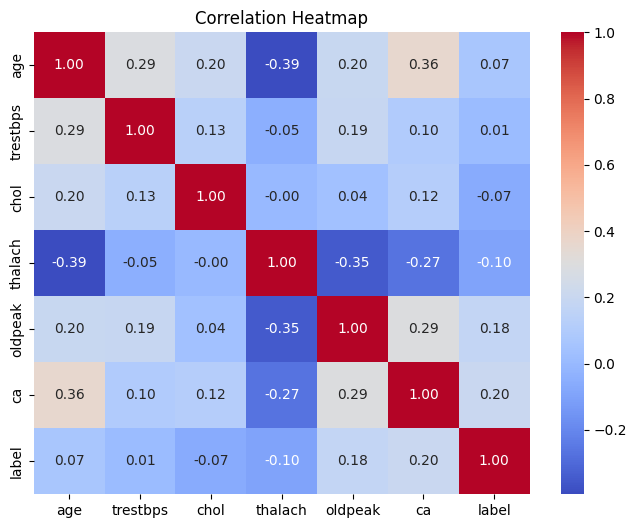

|          |   Mean (Absence) |   Mean (Presence) |   Squared Difference |   Correlation |
|----------|------------------|-------------------|----------------------|---------------|
| label    |       0          |         1         |          1           |   nan         |
| ca       |      -0.181908   |         0.223597  |          0.164435    |     0.463189  |
| oldpeak  |      -0.161538   |         0.193707  |          0.126199    |     0.424052  |
| thalach  |       0.0944497  |        -0.106216  |          0.0402668   |    -0.423817  |
| age      |      -0.0558513  |         0.0783567 |          0.0180118   |     0.227075  |
| chol     |       0.0633276  |        -0.0700838 |          0.0177986   |     0.0802848 |
| trestbps |      -0.00527848 |         0.0211234 |          0.000697061 |     0.15349   |
|    | Feature   |   Chi-Square |     p-value |
|----|-----------|--------------|-------------|
|  7 | label     |    292.989   | 1.10964e-65 |
|  6 | thal      |     82.4601  | 1.2

In [517]:
# Compute group means
group_means_0 = features_copy[features_copy['label'] == 0].mean()
group_means_1 = features_copy[features_copy['label'] == 1].mean()

# Compute squared differences and sort
squared_diff = (group_means_0 - group_means_1) ** 2
squared_diff_sorted = squared_diff.sort_values(ascending=False)

# Compute point-biserial correlations
numerical_correlations = {col: pointbiserialr(numerical_features[col], labels)[0] for col in numerical_features.columns}
correlations_sorted = sorted(numerical_correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Create table
stats_table = pd.DataFrame({
    'Mean (Absence)': group_means_0,
    'Mean (Presence)': group_means_1,
    'Squared Difference': squared_diff,
    'Correlation': pd.Series(numerical_correlations)
})


# Sort by squared difference
stats_table_sorted = stats_table.sort_values(by="Squared Difference", ascending=False)

# heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(features_copy.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

table_markdown = tabulate(stats_table_sorted, headers="keys", tablefmt="github")
print(table_markdown)

chi2_results = []

# Chi-Square test for each categorical feature
for col in categorical_features.columns:
    contingency_table = pd.crosstab(categorical_features[col], labels)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_results.append([col, chi2, p])

# Convert to DataFrame
chi2_df = pd.DataFrame(chi2_results, columns=["Feature", "Chi-Square", "p-value"])

# Sort by p-value (ascending)
chi2_df_sorted = chi2_df.sort_values(by="p-value")

print(tabulate(chi2_df_sorted, headers="keys", tablefmt="github", floatfmt=(".4f", ".15f")))

Remove unnecessary features

In [518]:
selected_features_numerical = numerical_features.drop(columns=['trestbps','chol'])
categorical_features = categorical_features.drop(columns='fbs')
# Combine numerical and categorical features
x_combined = np.hstack([x_standardized, x_categorical])

Task 3: Running experiments

1. Compare different way of splitting data for KNN, 2-split vs 3-split vs k-fold

In [287]:
# 3-split
x_train, y_train,x_validation, y_validation, x_test, y_test = split_data_three(x_combined, y)
_,accuracies_3,_ = best_K_simple(x_train, y_train, x_test, y_test, KNN)

K = 1, , Train Accuracy = 1.00, Test Accuracy = 0.91
K = 2, , Train Accuracy = 0.97, Test Accuracy = 0.91
K = 3, , Train Accuracy = 0.98, Test Accuracy = 0.92
K = 4, , Train Accuracy = 0.96, Test Accuracy = 0.93
K = 5, , Train Accuracy = 0.97, Test Accuracy = 0.92
K = 6, , Train Accuracy = 0.95, Test Accuracy = 0.91
K = 7, , Train Accuracy = 0.95, Test Accuracy = 0.92
K = 8, , Train Accuracy = 0.95, Test Accuracy = 0.93
K = 9, , Train Accuracy = 0.95, Test Accuracy = 0.93
K = 10, , Train Accuracy = 0.94, Test Accuracy = 0.92
K = 11, , Train Accuracy = 0.94, Test Accuracy = 0.92
K = 12, , Train Accuracy = 0.94, Test Accuracy = 0.90
K = 13, , Train Accuracy = 0.94, Test Accuracy = 0.93
K = 14, , Train Accuracy = 0.94, Test Accuracy = 0.91
K = 15, , Train Accuracy = 0.94, Test Accuracy = 0.91
K = 16, , Train Accuracy = 0.94, Test Accuracy = 0.91
K = 17, , Train Accuracy = 0.94, Test Accuracy = 0.92
K = 18, , Train Accuracy = 0.94, Test Accuracy = 0.91
K = 19, , Train Accuracy = 0.94, Test

In [343]:
#2-split
x_train, y_train, x_test, y_test = split_data(x_combined, y, train_ratio=0.5)
_,accuracies_2,_ = best_K_simple(x_train, y_train, x_test, y_test, KNN)

K = 1, , Train Accuracy = 1.00, Test Accuracy = 0.95
K = 2, , Train Accuracy = 0.95, Test Accuracy = 0.95
K = 3, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 4, , Train Accuracy = 0.95, Test Accuracy = 0.97
K = 5, , Train Accuracy = 0.97, Test Accuracy = 0.96
K = 6, , Train Accuracy = 0.96, Test Accuracy = 0.95
K = 7, , Train Accuracy = 0.96, Test Accuracy = 0.97
K = 8, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 9, , Train Accuracy = 0.96, Test Accuracy = 0.97
K = 10, , Train Accuracy = 0.96, Test Accuracy = 0.95
K = 11, , Train Accuracy = 0.97, Test Accuracy = 0.96
K = 12, , Train Accuracy = 0.96, Test Accuracy = 0.95
K = 13, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 14, , Train Accuracy = 0.95, Test Accuracy = 0.95
K = 15, , Train Accuracy = 0.95, Test Accuracy = 0.96
K = 16, , Train Accuracy = 0.94, Test Accuracy = 0.95
K = 17, , Train Accuracy = 0.95, Test Accuracy = 0.96
K = 18, , Train Accuracy = 0.94, Test Accuracy = 0.95
K = 19, , Train Accuracy = 0.95, Test

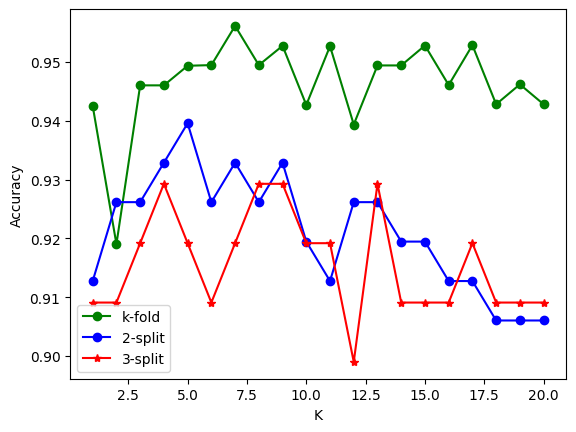

In [326]:
#k-fold cross-validation
K_values = range(1, 21)
acc_weighted, acc_knn = k_fold_cross_validation_sklearn(x_combined, y, K_values)

# Compute mean accuracies
mean_accuracies_weighted = [np.mean(acc_weighted[k]) for k in K_values]
mean_accuracies_knn = [np.mean(acc_knn[k]) for k in K_values]

# visulization
plt.clf()
plt.plot(K_values, mean_accuracies_knn, marker='o', color='green', label='k-fold')
plt.plot(K_values, accuracies_2, marker='o', color='blue', label='2-split')
plt.plot(K_values, accuracies_3, marker='*', color='red', label='3-split')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

Since 2-split has better performance than 3-split, we used 2-split for all the experiment below

Text(0.5, 0, 'trestbps')

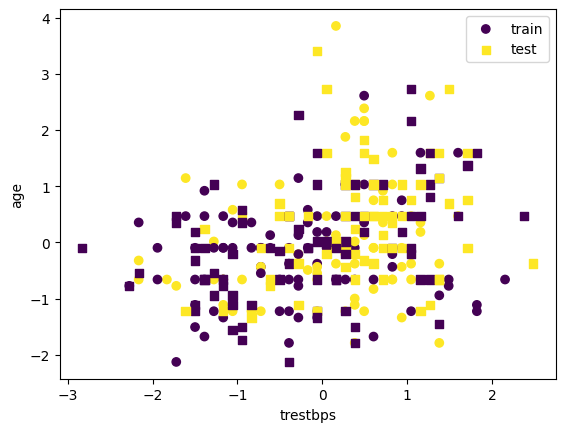

In [290]:
#visualization of the data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('age')
plt.xlabel('trestbps')

2. Test different K values and see how it affects the training data accuracy and test data accuracy of KNN.

In [354]:
x_train, y_train, x_test, y_test = split_data(x_combined, y, train_ratio=0.5)
best_K, test_acc, train_acc = best_K_simple(x_train, y_train, x_test, y_test,KNN)

K = 1, , Train Accuracy = 1.00, Test Accuracy = 0.93
K = 2, , Train Accuracy = 0.97, Test Accuracy = 0.93
K = 3, , Train Accuracy = 0.98, Test Accuracy = 0.95
K = 4, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 5, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 6, , Train Accuracy = 0.97, Test Accuracy = 0.94
K = 7, , Train Accuracy = 0.97, Test Accuracy = 0.94
K = 8, , Train Accuracy = 0.96, Test Accuracy = 0.94
K = 9, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 10, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 11, , Train Accuracy = 0.98, Test Accuracy = 0.94
K = 12, , Train Accuracy = 0.97, Test Accuracy = 0.94
K = 13, , Train Accuracy = 0.97, Test Accuracy = 0.94
K = 14, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 15, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 16, , Train Accuracy = 0.97, Test Accuracy = 0.93
K = 17, , Train Accuracy = 0.97, Test Accuracy = 0.93
K = 18, , Train Accuracy = 0.96, Test Accuracy = 0.93
K = 19, , Train Accuracy = 0.96, Test

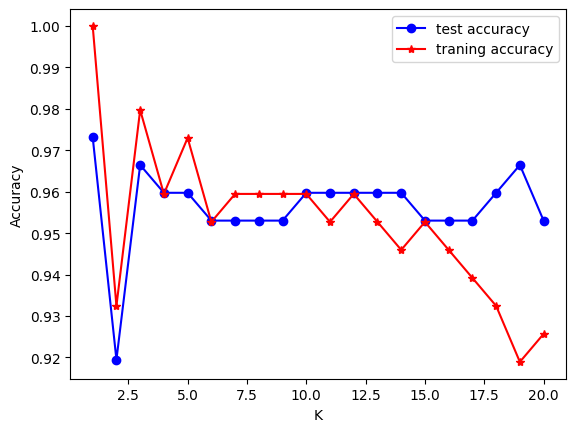

In [292]:
#Visulization
plt.clf()
plt.plot(range(1, 21), test_acc, marker='o', color='blue', label='test accuracy')
plt.plot(range(1, 21), train_acc, marker='*', color='red', label='traning accuracy')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Accuracy Visulization for KNN, using best k

knns shape: (149, 3)
y_prob shape: (149, 2)
accuracy is 95.3.


Text(0.5, 0, 'trestbps')

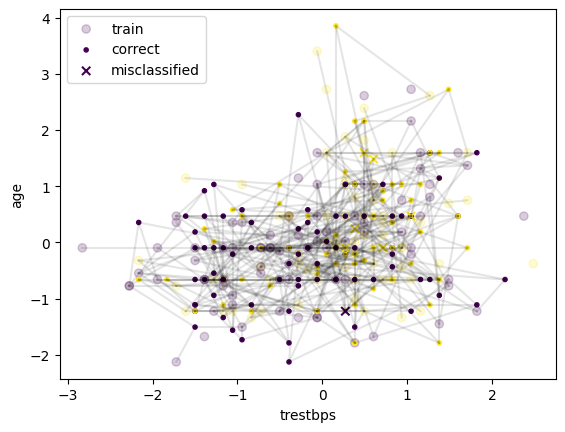

In [359]:
model = KNN(K=best_K)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)


#visualization of the points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)

plt.legend()
plt.ylabel('age')
plt.xlabel('trestbps')

Confusion matrix for KNN

In [360]:
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, index=['Actual Negative','Actual Positive'],
                     columns=['Predicted Negative', 'Predicted Positive'])
print(cm_df)

                 Predicted Negative  Predicted Positive
Actual Negative                  80                   1
Actual Positive                   6                  62


3. Test for Weighted KNN

In [294]:
best_Weighted_K, test_acc_weighted, _ = best_K_simple(x_train, y_train, x_test, y_test,WeightedKNN)

K = 1, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 2, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 3, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 4, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 5, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 6, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 7, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 8, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 9, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 10, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 11, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 12, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 13, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 14, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 15, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 16, , Train Accuracy = 1.00, Test Accuracy = 0.95
K = 17, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 18, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 19, , Train Accuracy = 1.00, Test

Accuracy Visulization for Weighted KNN, using best k

knns shape: (149, 1)
y_prob shape: (149, 2)
accuracy is 97.3.


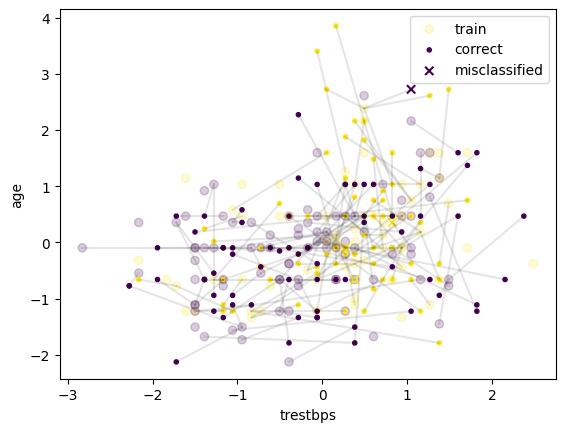

In [295]:
model = WeightedKNN(K=best_Weighted_K)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)


plt.ylabel('age')
plt.xlabel('trestbps')
plt.legend()

KNN vs Weighted KNN

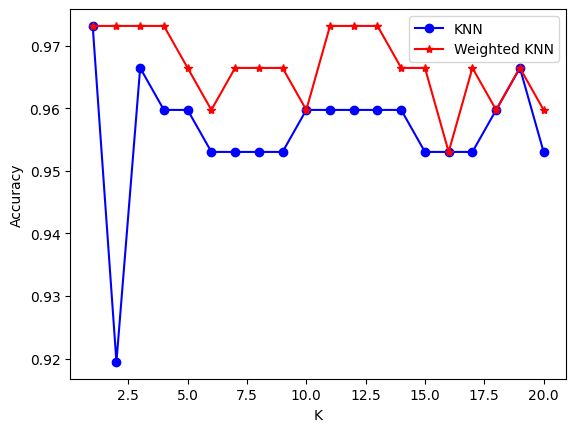

In [296]:
# Visulization
plt.clf()
plt.plot(range(1, 21), test_acc, marker='o', color='blue', label='KNN')
plt.plot(range(1, 21), test_acc_weighted, marker='*', color='red', label='Weighted KNN')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

4. Test different distance function using KNN

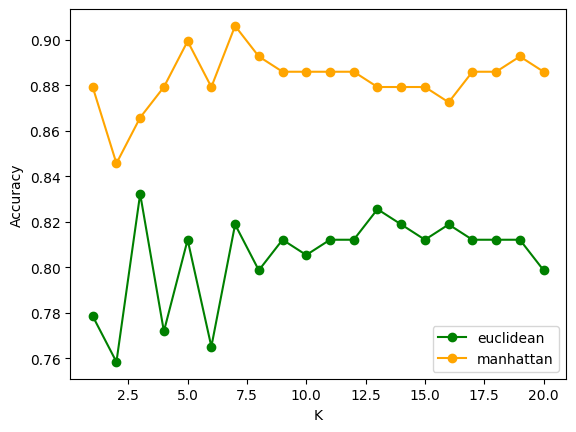

In [117]:
def dist_compare(x_train, y_train, x_test, y_test):
    K_values = range(1, 21)
    distance_functions = {
        'euclidean': euclidean,
        'manhattan': manhattan,
    }
    colors = {
        'euclidean': 'green',
        'manhattan': 'orange'
    }
    accuracies_dic = {}

    for (name, func), color in zip(distance_functions.items(), colors):
        accuracies = []

        # loop through k value 1-20
        for k in K_values:
            model = KNN(K=k, dist_fn=func)
            model.fit(x_train, y_train)
            y_prob, _ = model.predict(x_test)
            y_pred = np.argmax(y_prob, axis=-1)

            accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
            accuracies.append(accuracy)

        accuracies_dic[name] = accuracies

    for name, accuracies in accuracies_dic.items():
        plt.plot(K_values, accuracies, marker='o', linestyle='-', color=colors[name], label=name)

    plt.xlabel("K")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

dist_compare(x_train, y_train, x_test, y_test)

5. Test different cost functions on DT

Data preprocessing for DT

In [406]:
pip install ucimlrepo

In [407]:
# fetch dataset
heart_disease = fetch_ucirepo(id=45)


# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

heart_disease = pd.concat([X,y], axis = 1)

heart_disease.dropna(inplace=True)

# replace all values>1 in num(label) with 1, since it's a binary classification
heart_disease.loc[heart_disease['num'] > 1, 'num'] = 1
features_selected = features.drop(columns=['sex','fbs'])

y = labels.copy().to_numpy()
x_standardized = standadization(features_selected)

numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# initialize feature types
feature_types = np.zeros(features_selected.shape[1], dtype=str)

# loop through every features
for i, feature_name in enumerate(features_selected.columns):
    if feature_name in numerical_features:
        feature_types[i] = 'n'  # numerical features
    elif feature_name in categorical_features:
        feature_types[i] = 'c'  # categorical features
    else:
        feature_types[i] = 'unknown'  # none of numerical or categorical

<ipython-input-6-acf3cf3276d1>:14: RuntimeWarning: invalid value encountered in divide
  self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node


Depth: 1, Misclassification Accuracy: 74.5, Entropy Accuracy: 74.5, Gini Accuracy: 74.5
Depth: 2, Misclassification Accuracy: 72.5, Entropy Accuracy: 72.5, Gini Accuracy: 72.5
Depth: 3, Misclassification Accuracy: 75.8, Entropy Accuracy: 73.8, Gini Accuracy: 73.8
Depth: 4, Misclassification Accuracy: 72.5, Entropy Accuracy: 70.5, Gini Accuracy: 71.1
Depth: 5, Misclassification Accuracy: 75.2, Entropy Accuracy: 72.5, Gini Accuracy: 73.2
Depth: 6, Misclassification Accuracy: 73.2, Entropy Accuracy: 71.8, Gini Accuracy: 72.5
Depth: 7, Misclassification Accuracy: 71.8, Entropy Accuracy: 71.8, Gini Accuracy: 70.5
Depth: 8, Misclassification Accuracy: 70.5, Entropy Accuracy: 71.8, Gini Accuracy: 69.1
Depth: 9, Misclassification Accuracy: 70.5, Entropy Accuracy: 71.8, Gini Accuracy: 69.1
Depth: 10, Misclassification Accuracy: 69.8, Entropy Accuracy: 71.8, Gini Accuracy: 69.1
Depth: 11, Misclassification Accuracy: 69.1, Entropy Accuracy: 71.8, Gini Accuracy: 69.1
Depth: 12, Misclassification A

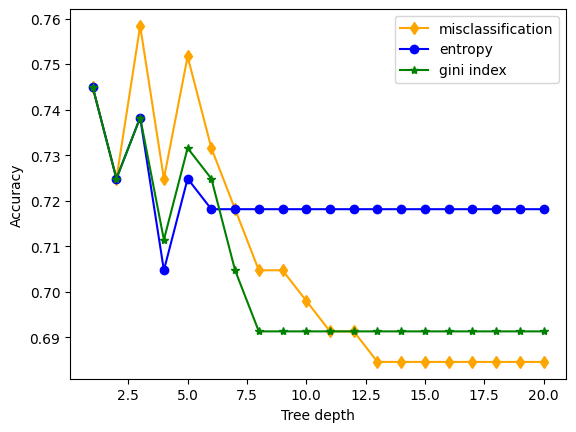

In [335]:
x_train_dt, y_train_dt, x_test_dt, y_test_dt = split_data(x_standardized, y, train_ratio=0.5)
misclassification_accuracies = []
entropy_accuracies = []
gini_accuracies = []

# loop through depth value 1-20
for depth in range(1, 21):
    # Misclassification cost
    miscla_tree = DecisionTree(max_depth=depth)
    probs_test = miscla_tree.fit(x_train_dt, y_train_dt).predict(x_test_dt)
    y_pred = np.argmax(probs_test, axis=1)
    accuracy = np.sum(y_pred == y_test_dt) / y_test_dt.shape[0]
    misclassification_accuracies.append(accuracy)

    # Entropy cost
    entropy_tree = DecisionTree(max_depth=depth, cost_fn=cost_entropy)
    probs_test = entropy_tree.fit(x_train_dt, y_train_dt).predict(x_test_dt)
    y_pred = np.argmax(probs_test, axis=1)
    accuracy = np.sum(y_pred == y_test_dt) / y_test_dt.shape[0]
    entropy_accuracies.append(accuracy)

    # Gini cost
    gini_tree = DecisionTree(max_depth=depth, cost_fn=cost_gini_index)
    probs_test = gini_tree.fit(x_train_dt, y_train_dt).predict(x_test_dt)
    y_pred = np.argmax(probs_test, axis=1)
    accuracy = np.sum(y_pred == y_test_dt) / y_test_dt.shape[0]
    gini_accuracies.append(accuracy)

for depth, mis_acc, ent_acc, gin_acc in zip(range(1, 21), misclassification_accuracies, entropy_accuracies, gini_accuracies):
    print(f"Depth: {depth}, Misclassification Accuracy: {mis_acc*100:.1f}, Entropy Accuracy: {ent_acc*100:.1f}, Gini Accuracy: {gin_acc*100:.1f}")


misclassification_accuracies = np.array(misclassification_accuracies)
entropy_accuracies = np.array(entropy_accuracies)
gini_accuracies = np.array(gini_accuracies)
all_accuracies = np.vstack([misclassification_accuracies, entropy_accuracies, gini_accuracies]).T
best_cost_fn = np.argmax(all_accuracies, axis=1)
best_acc_for_depth = np.max(all_accuracies, axis=1)

best_depth = np.argmax(best_acc_for_depth) + 1  # Index of the highest accuracy
best_accuracy = best_acc_for_depth[best_depth-1]
print(f"Best Depth: {best_depth}")
print(f"Accuracy: {best_accuracy * 100:.1f}%")

plt.plot(range(1, 21), misclassification_accuracies, marker='d', color='orange', label='misclassification')
plt.plot(range(1, 21), entropy_accuracies, marker='o', color='blue', label='entropy')
plt.plot(range(1, 21), gini_accuracies, marker='*', color='green', label='gini index')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Visualization using the best depth and misclaasification as cost function

accuracy is 74.5.


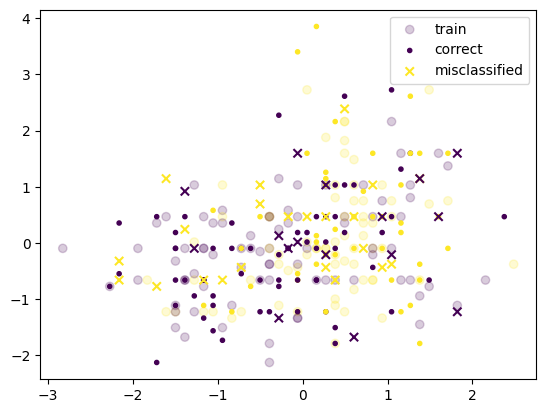

In [520]:
tree = DecisionTree(max_depth=best_depth)
probs_test = tree.fit(x_train_dt, y_train_dt).predict(x_test_dt)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test_dt)/y_test_dt.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#visualization
correct = y_test_dt == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train_dt[:,0], x_train_dt[:,1], c=y_train_dt, marker='o', alpha=.2, label='train')
plt.scatter(x_test_dt[correct,0], x_test_dt[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test_dt[incorrect,0], x_test_dt[incorrect,1], marker='x', c=y_test_dt[incorrect], label='misclassified')
plt.legend()
plt.show()

Top 5 important features

In [522]:
tree = DecisionTree(max_depth=5, cost_fn=cost_gini_index)
tree.fit(x_train_dt, y_train_dt)
tree.traverse_tree()  # Traverse the tree to calculate feature importances

# Normalize feature importances
tree.feature_importances /= np.sum(tree.feature_importances)

# Top 5 features
top_5_indices = np.argsort(tree.feature_importances)[-5:][::-1]
print("\nTop 5 Features:")
for idx in top_5_indices:
    print(f"Feature index: {idx}, Importance: {tree.feature_importances[idx]:.4f}")

# Top 5 Gini-based features
top_5_gini = np.argsort(tree.feature_importances_gini)[-5:][::-1]
print("\nTop 5 Gini-based Features:")
for idx in top_5_gini:
    print(f"Feature index: {idx}, Gini: {tree.feature_importances_gini[idx]}")



Top 5 Features:
Feature index: 0, Importance: 0.5385
Feature index: 4, Importance: 0.1154
Feature index: 3, Importance: 0.1154
Feature index: 2, Importance: 0.1154
Feature index: 1, Importance: 0.0769

Top 5 Gini-based Features:
Feature index: 4, Gini: 6.418476861114186e-17
Feature index: 5, Gini: 0.0
Feature index: 1, Gini: 0.0
Feature index: 0, Gini: -1.3877787807814457e-17
Feature index: 3, Gini: -5.551115123125783e-17


6. Finding best depth

<ipython-input-6-acf3cf3276d1>:14: RuntimeWarning: invalid value encountered in divide
  self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node


best depth = 2, test accuracy = 0.7248322147651006


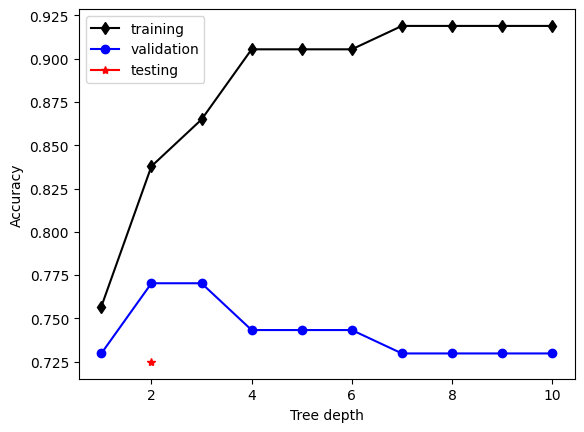

In [338]:
# further split the training data into 50% training and 50% validation
X_train_tr, y_train_tr, X_train_va, y_train_va = split_data(x_train_dt,y_train_dt)

model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
    dt = DecisionTree(max_depth=k)

    y_train_tr_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob = dt.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best depth = {best_depth}, test accuracy = {test_accuracy}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')

7. AUROC for comparing KNN, Weighted KNN and DT

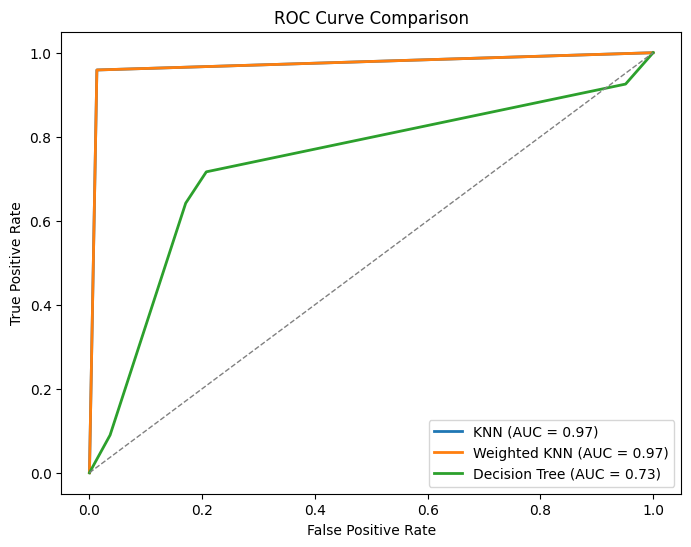

In [336]:
from sklearn.metrics import roc_curve, roc_auc_score

# initialize and train models
knn = KNN(K=best_K)
knn.fit(x_train, y_train)
y_prob_knn, _ = knn.predict(x_test)
y_test_prob_knn = y_prob_knn[:, 1]

weighted_knn = WeightedKNN(K=best_Weighted_K)
weighted_knn.fit(x_train, y_train)
y_prob_w_knn, _ = weighted_knn.predict(x_test)
y_test_prob_w_knn = y_prob_w_knn[:, 1]

dt = DecisionTree(max_depth=best_depth)
dt.fit(x_train_dt, y_train_dt)
y_prob_dt = dt.predict(x_test_dt)
y_test_prob_dt = y_prob_dt[:, 1]

# compute ROC Curves
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_test_prob_knn)
roc_auc_knn = roc_auc_score(y_test, y_test_prob_knn)

fpr_w_knn, tpr_w_knn, _ = roc_curve(y_test, y_test_prob_w_knn)
roc_auc_w_knn = roc_auc_score(y_test, y_test_prob_w_knn)

fpr_dt, tpr_dt, _ = roc_curve(y_test_dt, y_test_prob_dt)
roc_auc_dt = roc_auc_score(y_test_dt, y_test_prob_dt)

# visulization
plt.figure(figsize=(8,6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_knn:.2f})", lw=2)
plt.plot(fpr_w_knn, tpr_w_knn, label=f"Weighted KNN (AUC = {roc_auc_w_knn:.2f})", lw=2)
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})", lw=2)

# reference diagonal
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="best")
plt.show()


**Dataset 2: Penguins**

Task 1:

Load and clean data

In [523]:
!wget "https://raw.githubusercontent.com/Helen-Jiang719/comp551_datasets/refs/heads/main/penguins_size.csv"
!rm penguins_size.csv.*

--2025-01-31 21:59:54--  https://raw.githubusercontent.com/Helen-Jiang719/comp551_datasets/refs/heads/main/penguins_size.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13519 (13K) [text/plain]
Saving to: ‘penguins_size.csv.1’

penguins_size.csv.1 100%[===================>]  13.20K  --.-KB/s    in 0s      

2025-01-31 21:59:54 (94.0 MB/s) - ‘penguins_size.csv.1’ saved [13519/13519]



In [524]:
penguins = pd.read_csv('penguins_size.csv')
penguins = penguins.dropna()

# group means for different species
penguins_features = penguins.drop(['species','island','sex'], axis = 1) # select features
penguins_labels = penguins['species']
numeric_labels = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
penguins_copy = penguins_features.copy()
penguins_labels = penguins_labels.map(numeric_labels)
penguins_copy['labels'] = penguins_labels

Compute basic statistics

Adelie means:
 culmen_length_mm       38.823973
culmen_depth_mm        18.347260
flipper_length_mm     190.102740
body_mass_g          3706.164384
labels                  0.000000
dtype: float64 

Chinstrap means:
 culmen_length_mm       48.833824
culmen_depth_mm        18.420588
flipper_length_mm     195.823529
body_mass_g          3733.088235
labels                  1.000000
dtype: float64 

Gentoo means:
 culmen_length_mm       47.542500
culmen_depth_mm        15.002500
flipper_length_mm     217.233333
body_mass_g          5090.625000
labels                  2.000000
dtype: float64 

Feature rank for Adelie and Chinstrap:
 body_mass_g          724.893792
culmen_length_mm     100.197116
flipper_length_mm     32.727435
labels                 1.000000
culmen_depth_mm        0.005377
dtype: float64 

Feature rank for Chinstrap and Gentoo:
 body_mass_g          1.842906e+06
flipper_length_mm    4.583797e+02
culmen_depth_mm      1.168333e+01
culmen_length_mm     1.667516e+00
labels       

<Axes: >

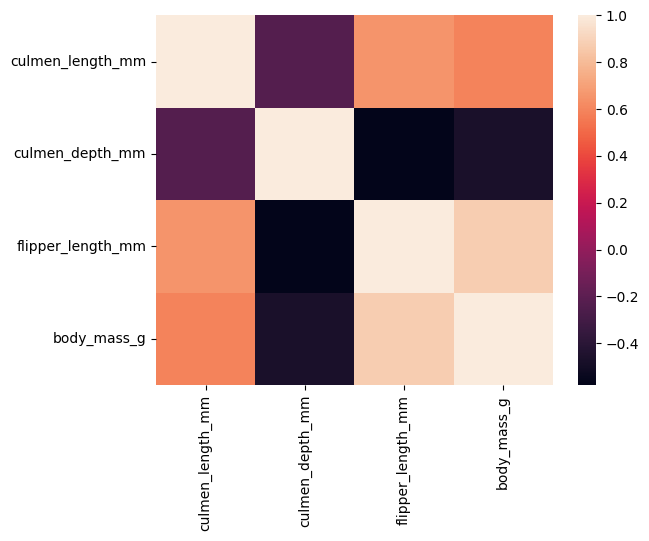

In [525]:
adelie_means = penguins_copy[penguins_copy['labels']==0].mean(numeric_only=True)
chinstrap_means = penguins_copy[penguins_copy['labels']==1].mean(numeric_only=True)
gentoo_means = penguins_copy[penguins_copy['labels']==2].mean(numeric_only=True)

print("Adelie means:\n", adelie_means, '\n')
print("Chinstrap means:\n", chinstrap_means, '\n')
print("Gentoo means:\n", gentoo_means, '\n')

# Rank the squared difference of the group means

# Difference between Adelie and Chinstrap
adelie_chinstrap_diff = (adelie_means - chinstrap_means) ** 2
rank_ac = adelie_chinstrap_diff.sort_values(ascending=False)
print('Feature rank for Adelie and Chinstrap:\n', rank_ac, "\n")

# Difference between Chinstrap and Gentoo
chinstrap_gentoo_diff = (chinstrap_means - gentoo_means) ** 2
rank_cg = chinstrap_gentoo_diff.sort_values(ascending=False)
print('Feature rank for Chinstrap and Gentoo:\n', rank_cg, "\n")

# Difference between Adelie and Gentoo
adelie_gentoo_diff = (adelie_means - gentoo_means) ** 2
rank_ag = adelie_gentoo_diff.sort_values(ascending=False)
print('Feature rank for Adelie and Gentoo:\n', rank_ag)
sb.heatmap(penguins_features.corr())

Remove unnecessary features

In [369]:
x_penguins, y_penguins = penguins_features, penguins_labels.to_numpy()
x_penguins = x_penguins.drop(columns='culmen_depth_mm')
x_penguins = standadization(x_penguins)

Task 3: Running experiments

1. Compare different way of splitting data for KNN, 2-split vs 3-split vs k-fold

In [379]:
# 3-split
x_train, y_train,x_validation, y_validation, x_test, y_test = split_data_three(x_penguins, y_penguins)
_,accuracies_3,_ = best_K_simple(x_train, y_train, x_test, y_test, KNN)

K = 1, , Train Accuracy = 1.00, Test Accuracy = 0.94
K = 2, , Train Accuracy = 0.99, Test Accuracy = 0.94
K = 3, , Train Accuracy = 0.99, Test Accuracy = 0.95
K = 4, , Train Accuracy = 0.99, Test Accuracy = 0.95
K = 5, , Train Accuracy = 0.99, Test Accuracy = 0.95
K = 6, , Train Accuracy = 0.99, Test Accuracy = 0.95
K = 7, , Train Accuracy = 0.99, Test Accuracy = 0.95
K = 8, , Train Accuracy = 0.99, Test Accuracy = 0.95
K = 9, , Train Accuracy = 0.99, Test Accuracy = 0.94
K = 10, , Train Accuracy = 0.98, Test Accuracy = 0.95
K = 11, , Train Accuracy = 0.99, Test Accuracy = 0.95
K = 12, , Train Accuracy = 0.98, Test Accuracy = 0.95
K = 13, , Train Accuracy = 0.98, Test Accuracy = 0.95
K = 14, , Train Accuracy = 0.98, Test Accuracy = 0.93
K = 15, , Train Accuracy = 0.98, Test Accuracy = 0.93
K = 16, , Train Accuracy = 0.95, Test Accuracy = 0.93
K = 17, , Train Accuracy = 0.97, Test Accuracy = 0.93
K = 18, , Train Accuracy = 0.96, Test Accuracy = 0.93
K = 19, , Train Accuracy = 0.98, Test

In [372]:
#2-split
x_train, y_train, x_test, y_test = split_data(x_penguins, y_penguins, train_ratio=0.5)
_,accuracies_2,_ = best_K_simple(x_train, y_train, x_test, y_test, KNN)

K = 1, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 2, , Train Accuracy = 0.98, Test Accuracy = 0.96
K = 3, , Train Accuracy = 0.96, Test Accuracy = 0.97
K = 4, , Train Accuracy = 0.97, Test Accuracy = 0.96
K = 5, , Train Accuracy = 0.97, Test Accuracy = 0.96
K = 6, , Train Accuracy = 0.97, Test Accuracy = 0.96
K = 7, , Train Accuracy = 0.98, Test Accuracy = 0.96
K = 8, , Train Accuracy = 0.97, Test Accuracy = 0.96
K = 9, , Train Accuracy = 0.98, Test Accuracy = 0.96
K = 10, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 11, , Train Accuracy = 0.98, Test Accuracy = 0.95
K = 12, , Train Accuracy = 0.97, Test Accuracy = 0.96
K = 13, , Train Accuracy = 0.97, Test Accuracy = 0.95
K = 14, , Train Accuracy = 0.95, Test Accuracy = 0.96
K = 15, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 16, , Train Accuracy = 0.96, Test Accuracy = 0.95
K = 17, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 18, , Train Accuracy = 0.95, Test Accuracy = 0.95
K = 19, , Train Accuracy = 0.96, Test

In [373]:
#k-fold cross-validation
K_values = range(1, 21)
acc_weighted, acc_knn = k_fold_cross_validation_sklearn(x_penguins, y_penguins, K_values)

# Compute mean accuracies
mean_accuracies_weighted = [np.mean(acc_weighted[k]) for k in K_values]
mean_accuracies_knn = [np.mean(acc_knn[k]) for k in K_values]


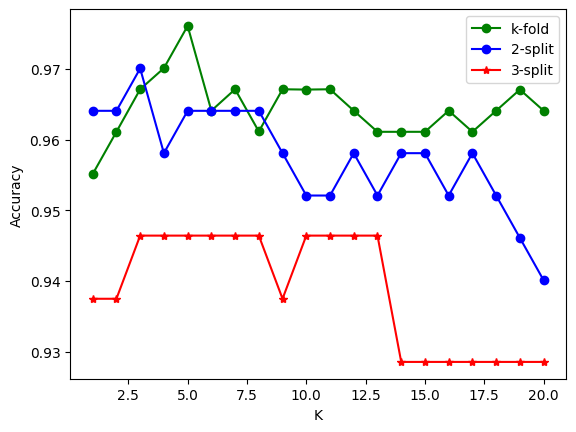

In [380]:
# visulization
plt.clf()
plt.plot(K_values, mean_accuracies_knn, marker='o', color='green', label='k-fold')
plt.plot(K_values, accuracies_2, marker='o', color='blue', label='2-split')
plt.plot(K_values, accuracies_3, marker='*', color='red', label='3-split')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

Since 2-split has better performance than 3-split, we used 2-split for all the experiment below

Text(0.5, 0, 'flipper_length_mm')

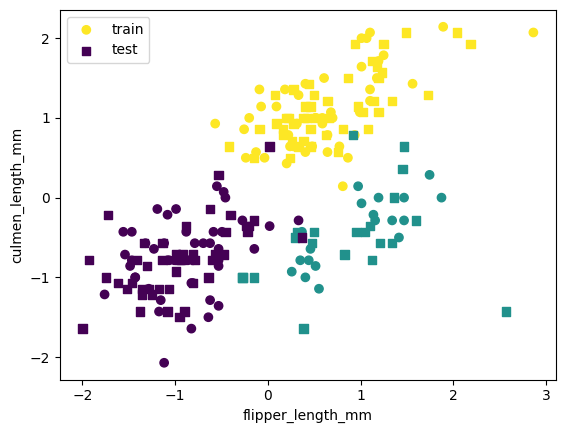

In [382]:
#visualization of the data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('culmen_length_mm')
plt.xlabel('flipper_length_mm')

2. Test different K values and see how it affects the training data accuracy and test data accuracy of KNN.

In [383]:
x_train, y_train, x_test, y_test = split_data(x_penguins, y_penguins, train_ratio=0.5)
best_K, test_acc, train_acc = best_K_simple(x_train, y_train, x_test, y_test,KNN)

K = 1, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 2, , Train Accuracy = 0.99, Test Accuracy = 0.95
K = 3, , Train Accuracy = 0.98, Test Accuracy = 0.96
K = 4, , Train Accuracy = 0.97, Test Accuracy = 0.97
K = 5, , Train Accuracy = 0.97, Test Accuracy = 0.97
K = 6, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 7, , Train Accuracy = 0.98, Test Accuracy = 0.97
K = 8, , Train Accuracy = 0.96, Test Accuracy = 0.97
K = 9, , Train Accuracy = 0.96, Test Accuracy = 0.97
K = 10, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 11, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 12, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 13, , Train Accuracy = 0.96, Test Accuracy = 0.97
K = 14, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 15, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 16, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 17, , Train Accuracy = 0.96, Test Accuracy = 0.97
K = 18, , Train Accuracy = 0.96, Test Accuracy = 0.96
K = 19, , Train Accuracy = 0.96, Test

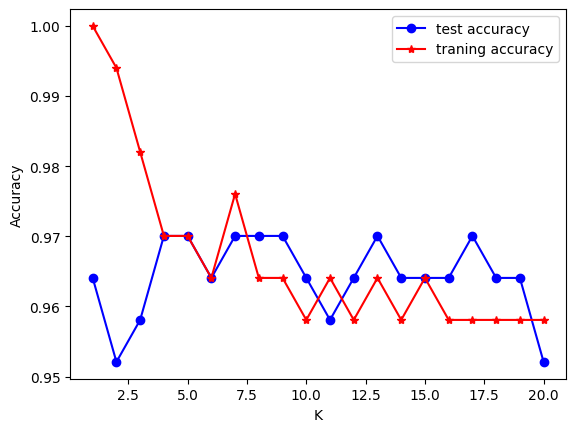

In [384]:
#Visulization
plt.clf()
plt.plot(range(1, 21), test_acc, marker='o', color='blue', label='test accuracy')
plt.plot(range(1, 21), train_acc, marker='*', color='red', label='traning accuracy')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Accuracy Visulization for KNN, using best k

knns shape: (167, 4)
y_prob shape: (167, 3)
accuracy is 97.0.


Text(0.5, 0, 'trestbps')

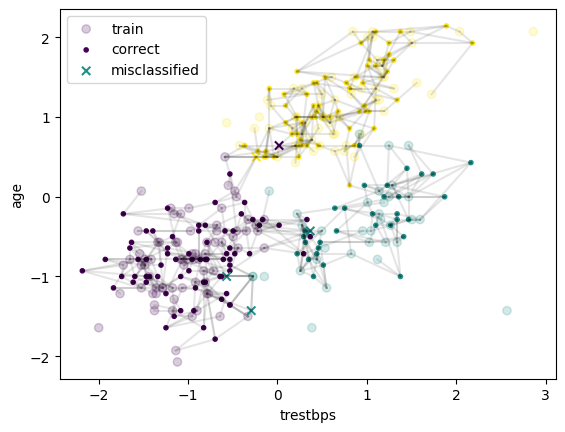

In [385]:
model = KNN(K=best_K)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)


#visualization of the points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)

plt.legend()
plt.ylabel('age')
plt.xlabel('trestbps')

Confusion matrix for KNN

In [387]:
confusion_matrix = confusion_matrix(y_test, y_pred)

# get class label of y_test
class_labels = np.unique(y_test)

confusion_matrix_df = pd.DataFrame(confusion_matrix,
                     index=[f'Actual {label}' for label in class_labels],
                     columns=[f'Predicted {label}' for label in class_labels])

print(confusion_matrix_df)

          Predicted 0  Predicted 1  Predicted 2
Actual 0           72            0            1
Actual 1            3           31            0
Actual 2            1            0           59


3. Test for Weighted KNN

In [388]:
best_Weighted_K, test_acc_weighted, _ = best_K_simple(x_train, y_train, x_test, y_test,WeightedKNN)

K = 1, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 2, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 3, , Train Accuracy = 1.00, Test Accuracy = 0.95
K = 4, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 5, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 6, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 7, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 8, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 9, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 10, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 11, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 12, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 13, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 14, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 15, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 16, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 17, , Train Accuracy = 1.00, Test Accuracy = 0.96
K = 18, , Train Accuracy = 1.00, Test Accuracy = 0.97
K = 19, , Train Accuracy = 1.00, Test

Accuracy Visulization for Weighted KNN, using best k

knns shape: (167, 5)
y_prob shape: (167, 3)
accuracy is 97.0.


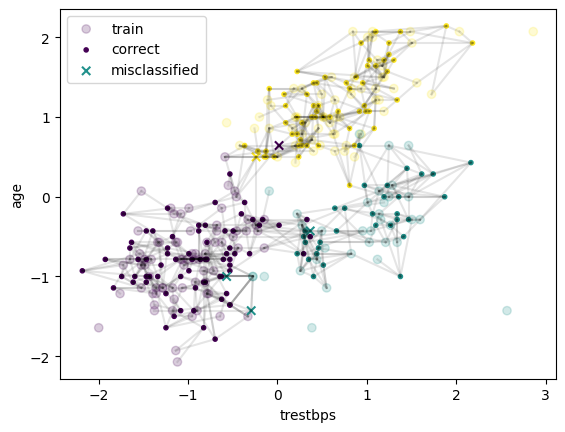

In [389]:
model = WeightedKNN(K=best_Weighted_K)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)


plt.ylabel('age')
plt.xlabel('trestbps')
plt.legend()

KNN vs Weighted KNN

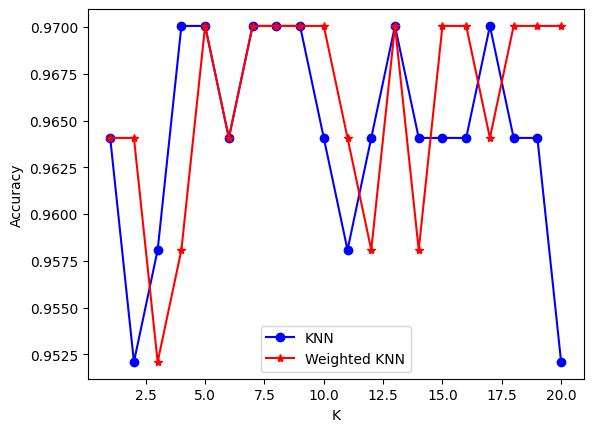

In [390]:
# Visulization
plt.clf()
plt.plot(range(1, 21), test_acc, marker='o', color='blue', label='KNN')
plt.plot(range(1, 21), test_acc_weighted, marker='*', color='red', label='Weighted KNN')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')

4. Test different distance function using KNN

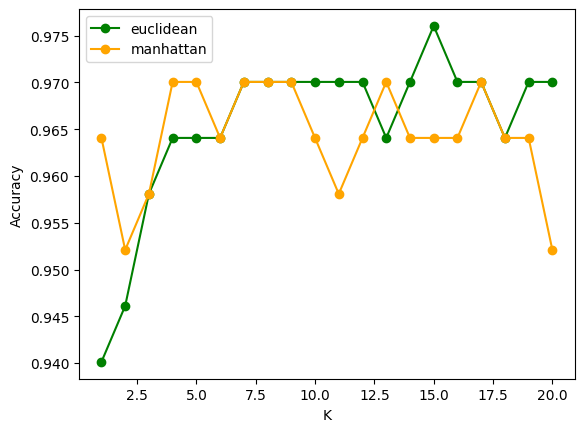

In [392]:
dist_compare(x_train, y_train, x_test, y_test)

5. Test different cost functions on DT

Modify fit function for for penguins using another greedy test

In [526]:
def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test_penguins(node, self.cost_fn)

    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

Depth: 1, Misclassification Accuracy: 76.6, Entropy Accuracy: 76.6, Gini Accuracy: 77.8
Depth: 2, Misclassification Accuracy: 91.0, Entropy Accuracy: 91.0, Gini Accuracy: 92.2
Depth: 3, Misclassification Accuracy: 91.0, Entropy Accuracy: 91.0, Gini Accuracy: 91.6
Depth: 4, Misclassification Accuracy: 91.6, Entropy Accuracy: 90.4, Gini Accuracy: 92.2
Depth: 5, Misclassification Accuracy: 91.6, Entropy Accuracy: 91.0, Gini Accuracy: 92.2
Depth: 6, Misclassification Accuracy: 91.6, Entropy Accuracy: 91.0, Gini Accuracy: 91.6
Depth: 7, Misclassification Accuracy: 91.0, Entropy Accuracy: 91.0, Gini Accuracy: 91.6
Depth: 8, Misclassification Accuracy: 91.0, Entropy Accuracy: 91.0, Gini Accuracy: 91.6
Depth: 9, Misclassification Accuracy: 91.0, Entropy Accuracy: 91.0, Gini Accuracy: 91.6
Depth: 10, Misclassification Accuracy: 91.0, Entropy Accuracy: 91.0, Gini Accuracy: 91.6
Best Depth: 2
Accuracy: 92.2%


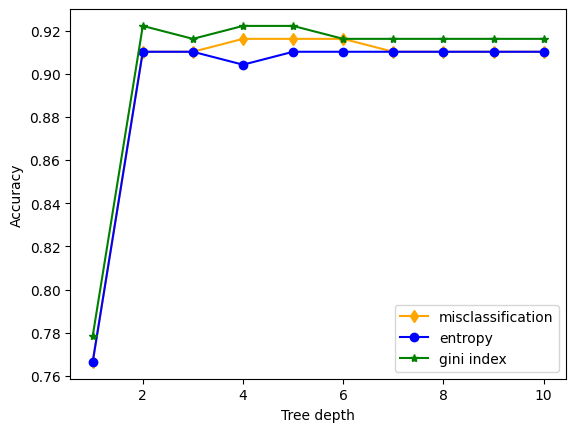

In [527]:
x_train, y_train, x_test, y_test = split_data(x_penguins, y_penguins, train_ratio=0.5)

misclassification_accuracies = []
entropy_accuracies = []
gini_accuracies = []

# loop through depth value 1-10
for depth in range(1, 11):
    # Misclassification cost
    miscla_tree = DecisionTree(max_depth=depth)
    probs_test = miscla_tree.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(probs_test, axis=1)
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    misclassification_accuracies.append(accuracy)

    # Entropy cost
    entropy_tree = DecisionTree(max_depth=depth, cost_fn=cost_entropy)
    probs_test = entropy_tree.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(probs_test, axis=1)
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    entropy_accuracies.append(accuracy)

    # Gini cost
    gini_tree = DecisionTree(max_depth=depth, cost_fn=cost_gini_index)
    probs_test = gini_tree.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(probs_test, axis=1)
    accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
    gini_accuracies.append(accuracy)

for depth, mis_acc, ent_acc, gin_acc in zip(range(1, 21), misclassification_accuracies, entropy_accuracies, gini_accuracies):
    print(f"Depth: {depth}, Misclassification Accuracy: {mis_acc*100:.1f}, Entropy Accuracy: {ent_acc*100:.1f}, Gini Accuracy: {gin_acc*100:.1f}")

misclassification_accuracies = np.array(misclassification_accuracies)
entropy_accuracies = np.array(entropy_accuracies)
gini_accuracies = np.array(gini_accuracies)
all_accuracies = np.vstack([misclassification_accuracies, entropy_accuracies, gini_accuracies]).T
best_cost_fn = np.argmax(all_accuracies, axis=1)
best_acc_for_depth = np.max(all_accuracies, axis=1)

best_depth = np.argmax(best_acc_for_depth) + 1  # Index of the highest accuracy
best_accuracy = best_acc_for_depth[best_depth-1]
print(f"Best Depth: {best_depth}")
print(f"Accuracy: {best_accuracy * 100:.1f}%")

plt.plot(range(1, 11), misclassification_accuracies, marker='d', color='orange', label='misclassification')
plt.plot(range(1, 11), entropy_accuracies, marker='o', color='blue', label='entropy')
plt.plot(range(1, 11), gini_accuracies, marker='*', color='green', label='gini index')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')

Visualization using the best depth and misclaasification as cost function

accuracy is 94.0.


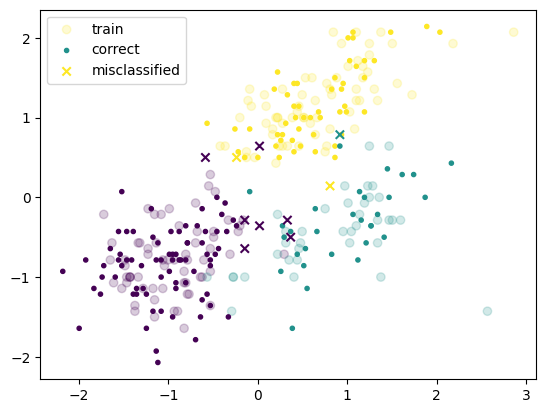

In [500]:
tree = DecisionTree(max_depth=best_depth)
probs_test = tree.fit(x_train, y_train).predict(x_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')
#visualization
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
plt.legend()
plt.show()

Rank feature importance

In [530]:
tree = DecisionTree(max_depth=5, cost_fn=cost_gini_index)
tree.fit(x_train, y_train)
tree.traverse_tree()  # Traverse the tree to calculate feature importances

# Normalize feature importances
tree.feature_importances /= np.sum(tree.feature_importances)

# Rank features
indices = np.argsort(tree.feature_importances)[-5:][::-1]
print("\nFeatures ranking:")
for idx in indices:
    print(f"Feature index: {idx}, Importance: {tree.feature_importances[idx]:.4f}")

# Top 5 Gini-based features
gini_indices = np.argsort(tree.feature_importances_gini)[-5:][::-1]
print("\nTop 5 Gini-based Features:")
for idx in gini_indices:
    print(f"Feature index: {idx}, Gini: {tree.feature_importances_gini[idx]}")



Features ranking:
Feature index: 0, Importance: 0.7500
Feature index: 1, Importance: 0.1500
Feature index: 2, Importance: 0.1000

Top 5 Gini-based Features:
Feature index: 0, Gini: 2.3592239273284576e-16
Feature index: 1, Gini: 0.0
Feature index: 2, Gini: -7.979727989493313e-17


6. Finding best depth

best depth = 2, test accuracy = 0.9401197604790419


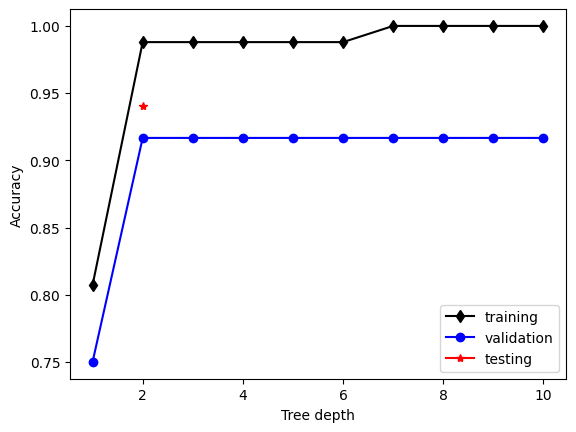

In [502]:
# further split the training data into 50% training and 50% validation
X_train_tr, y_train_tr, X_train_va, y_train_va = split_data(x_train,y_train)

model_choices=[]
train_acc = []
valid_acc = []

n_train = y_train_tr.shape[0]
n_valid = y_train_va.shape[0]

for k in range(1, 11):
    dt = DecisionTree(max_depth=k)

    y_train_tr_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_tr)
    y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
    acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

    y_train_va_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_va)
    y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
    acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

    model_choices.append(k)
    train_acc.append(acc_tr)
    valid_acc.append(acc_va)

# use the best K to predict test data
best_depth = model_choices[valid_acc.index(max(valid_acc))]
dt = DecisionTree(max_depth=best_depth)
y_test_prob = dt.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best depth = {best_depth}, test accuracy = {test_accuracy}')

plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend(loc='best')